## Imports

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Flatten
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import StratifiedKFold

## Data Preparations

### 1. Load data files

In [3]:
# load the data from keras datasets
fashion_mnist = tf.keras.datasets.fashion_mnist
# divide the data into train and test
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data() 

4422102/4422102 [==============================] - 0s 0us/step


### 1.1 Describe the data

In [4]:
# shape of train data
print('The train data has', X_train.shape[0], 'examples with shape', X_train.shape[1:])

The train data has 60000 examples with shape (28, 28)


In [5]:
# shape of test data
print('The test data has', X_test.shape[0], 'examples with shape', X_test.shape[1:])

The test data has 10000 examples with shape (28, 28)


In [6]:
classes_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
unique_labels = np.unique(y_train)
labels_dict = {classes_names[i]: unique_labels[i] for i in range(len(unique_labels))}
for class_name, label in labels_dict.items():
    print('The label', label, 'represents a class that is', class_name)

The label 0 represents a class that is T-shirt/top
The label 1 represents a class that is Trouser
The label 2 represents a class that is Pullover
The label 3 represents a class that is Dress
The label 4 represents a class that is Coat
The label 5 represents a class that is Sandal
The label 6 represents a class that is Shirt
The label 7 represents a class that is Sneaker
The label 8 represents a class that is Bag
The label 9 represents a class that is Ankle boot


### 1.5 Draw some of the images

Some of the images from fashion-MNIST:


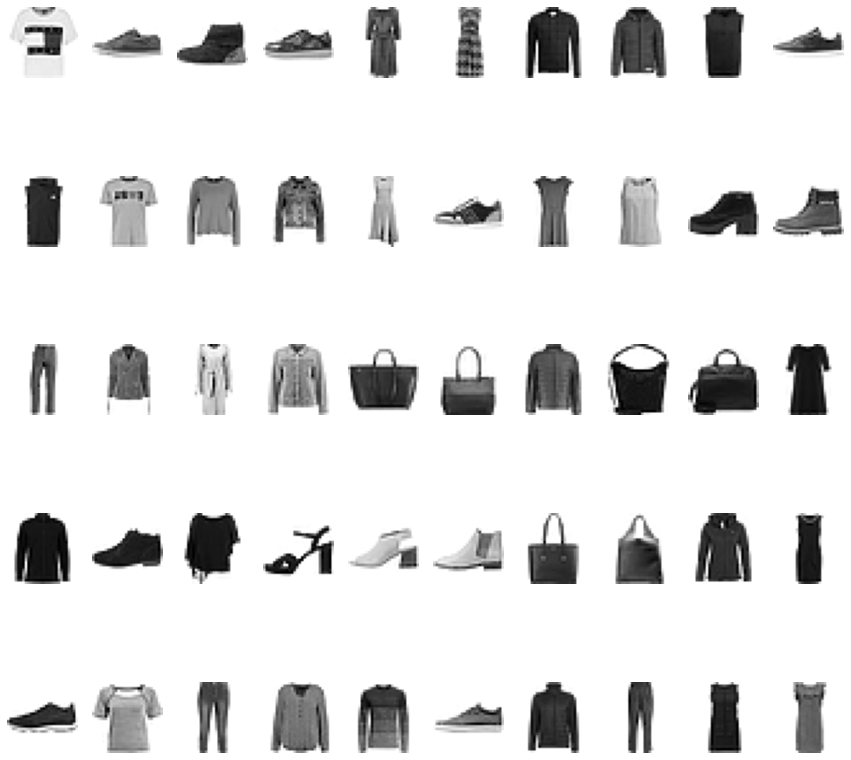

In [7]:
def draw_images(data, num_of_images):
    '''
    This function draws a random images from the data, by specifying how many images to draw
    '''
    random_indexes = [np.random.randint(0, len(X_train)) for i in range(num_of_images)]
    fig , axis = plt.subplots(5,10)
    fig.set_figwidth(15)
    fig.set_figheight(15)
    i , j = 0 , 0
    for idx in random_indexes:
        image = X_train[idx]
        axis[i,j].imshow(image, cmap='binary')
        axis[i,j].axis('off')
        j += 1
        if j % 10 == 0:
            i += 1
            j = 0
# draw some images
print('Some of the images from fashion-MNIST:')
draw_images(data=X_train, num_of_images=50)

### 2. Carry out required preprocessing operations on the data

In [8]:
# normalize train and test data
X_train = X_train / 255.0
X_test = X_test / 255.0
# add channel dimension for train and test data to be suitable for the CNN network
X_train = np.expand_dims(X_train,axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

### 3. Encode the labels

In [9]:
# encode train and test labels
y_train_encoded = pd.get_dummies(y_train)
y_test_encoded = pd.get_dummies(y_test)

## Training a CNN neural network

### Plot Utility

In [10]:
def train_curves(history, special_title):
    '''
    This function draws accuracy and loss curves for each epoch between train and validation data
    '''
    title_loss = 'Model loss per epoch ' + special_title
    title_accuracy = 'Model accuracy per epoch ' + special_title
    fig , axis = plt.subplots(nrows=1, ncols=2)
    # dimensions of figure
    fig.set_figheight(6)
    fig.set_figwidth(14)
    # loss
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    # accuracy
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    epoch = np.arange(150)
    # loss curve
    axis[0].plot(loss,label='Train')
    axis[0].plot(val_loss,label='Validation')
    axis[0].set_xlabel('epoch')
    axis[0].set_ylabel('loss')
    axis[0].set_title(title_loss)
    axis[0].legend()
    # accuracy curve
    axis[1].plot(accuracy, label='Train')
    axis[1].plot(val_accuracy, label='Validation')
    axis[1].set_xlabel('epoch')
    axis[1].set_ylabel('accuracy')
    axis[1].set_title(title_accuracy)
    axis[1].legend()

### Evaluation Utilities

In [13]:
def k_fold_cross_validation(X, y, model, k):
  '''
  This function evaluates the model by performing k fold cross validation
  '''
  # instantiate k_fold 
  k_fold = StratifiedKFold(k, shuffle=True, random_state=42)
  # output lists that will hold accuracy and loss for both train and validation
  # for each fold
  history_list = []
  accuracy_list = []
  val_accuracy_list = []
  val_loss_list = []
  loss_list = []
  # loop through the 5 folds
  for train_idx , val_idx in k_fold.split(X,y):
    # determine from the train data which fold will be used for validation, and the other will be for training
    X_train , y_train = X[train_idx], y[train_idx]
    X_val , y_val = X[val_idx], y[val_idx]
    # encode the labels
    y_train , y_val = pd.get_dummies(y_train) , pd.get_dummies(y_val)
    # training...
    history = model.fit(x= X_train, y= y_train, epochs=25, batch_size= 256, validation_data= (X_val, y_val), verbose= 0)
    # accuracy and loss after the completion of training
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    history_list.append(history)
    accuracy_list.append(accuracy)
    loss_list.append(loss)
    val_accuracy_list.append(val_accuracy)
    val_loss_list.append(val_loss)
  # get the mean of results for all folds
  mean_accuracy = np.mean(accuracy_list)
  mean_val_accuracy = np.mean(val_accuracy_list)
  mean_loss = np.mean(loss_list)
  mean_val_loss = np.mean(val_loss_list)
  return history_list, mean_accuracy, mean_val_accuracy, mean_loss,  mean_val_loss

In [14]:
def cross_validation_report(history_list, mean_accuracy, mean_val_accuracy, mean_loss,  mean_val_loss, k):
  print('The mean accuracy of the model after', k, 'fold cross validation is:', mean_accuracy)
  print('The mean validation accuracy of the model after', k, 'fold cross validation is:', mean_val_accuracy)
  print('The mean loss of the model after', k, 'fold cross validation is:', mean_loss)
  print('The mean validation loss of the model after', k, 'fold cross validation is:', mean_val_loss)
  for i, history in enumerate(history_list,start=1):
    train_curves(history, 'of fold-' + str(i) + ' for LeNet-5')

### LeNet-5 Architecture

In [15]:
def lenet_5(filters1 = 6, kernel_size1 = (5,5), strides1 = (1,1), padding1 = 'valid', pool_size2 = (2,2), strides2 = 2, filters3 = 16, 
            kernel_size3 = (5,5), strides3 = (1,1), padding3 = 'valid', pool_size4 = (2,2), strides4 = 2, units5 = 120, units6 = 84):
    '''
    This function defines the architecure of LeNet-5
    '''
    # define architecture
    model = Sequential([
        Input(shape=(28,28,1)),
        Conv2D(filters= filters1, kernel_size= kernel_size1, strides= strides1, padding= padding1),
        AveragePooling2D(pool_size = pool_size2, strides = strides2),
        Conv2D(filters= filters3, kernel_size= kernel_size3, strides= strides3, padding= padding3),
        AveragePooling2D(pool_size= pool_size4, strides= strides4),
        Flatten(),
        Dense(units= units5, activation= 'relu'),
        Dense(units= units6, activation= 'relu'),
        Dense(units= 10, activation= 'softmax')
    ])
    # compile the model
    model.compile(optimizer=Adam(), loss=CategoricalCrossentropy(), metrics=['accuracy'])
    return model

In [16]:
# initialize the model and output the model summary
lenet5 = lenet_5()
lenet5.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 6)         156       
                                                                 
 average_pooling2d (AverageP  (None, 12, 12, 6)        0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 16)          2416      
                                                                 
 average_pooling2d_1 (Averag  (None, 4, 4, 16)         0         
 ePooling2D)                                                     
                                                                 
 flatten (Flatten)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 120)               3

The mean accuracy of the model after 5 fold cross validation is: 0.930488498210907
The mean validation accuracy of the model after 5 fold cross validation is: 0.9101273293495178
The mean loss of the model after 5 fold cross validation is: 0.1871023171544075
The mean validation loss of the model after 5 fold cross validation is: 0.25327518421411516


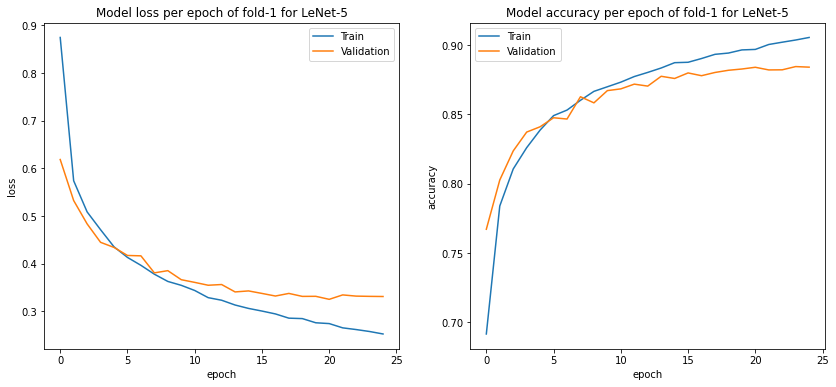

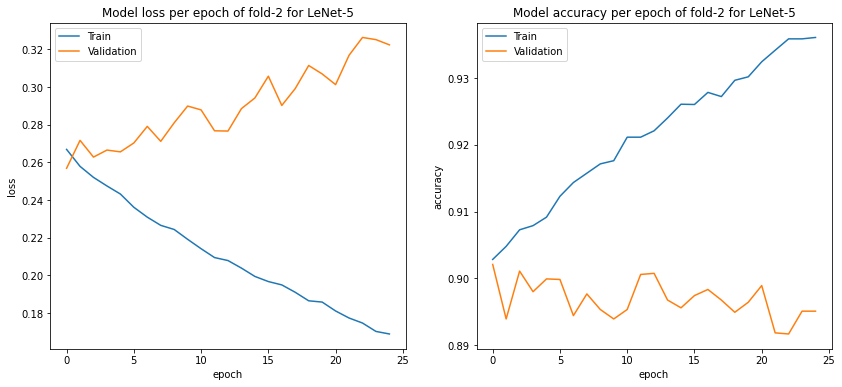

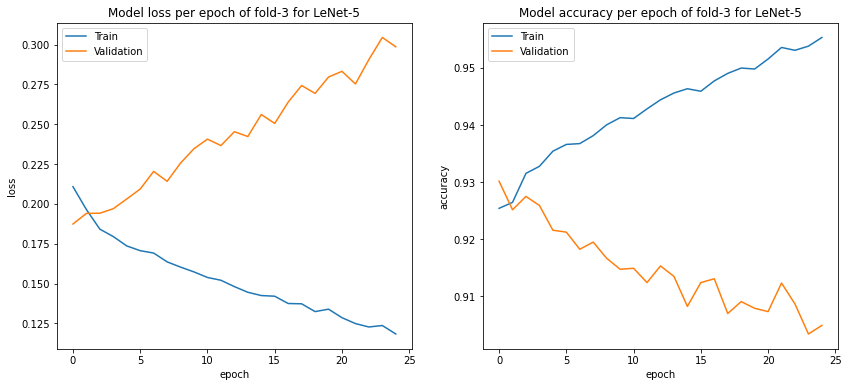

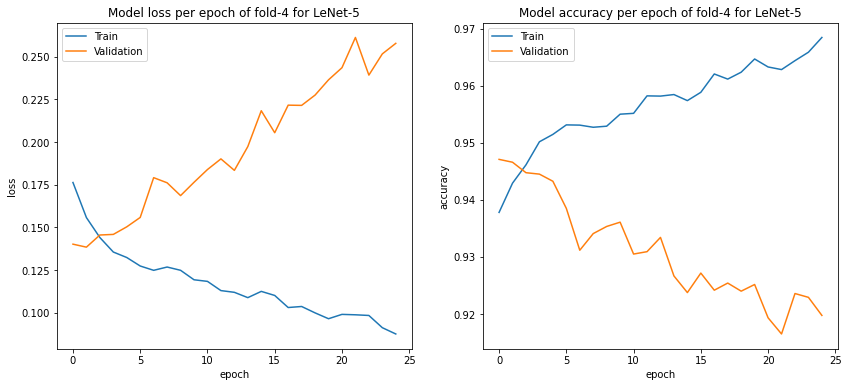

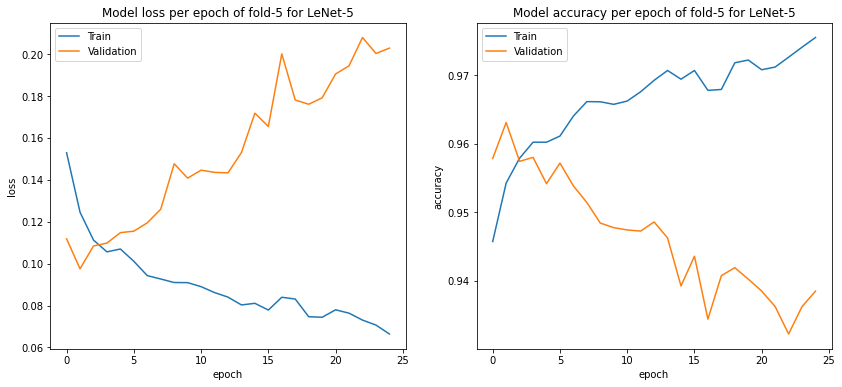

In [21]:
# perform 5 fold cross validation on the LeNet-5 model and visualize the results
histories, mean_accuracy, mean_validation_accuracy, mean_loss, mean_validation_loss = k_fold_cross_validation(X_train, y_train, lenet5, 5)
cross_validation_report(histories, mean_accuracy, mean_validation_accuracy, mean_loss, mean_validation_loss, 5)

### Modify the Hyperparameters of LeNet-5 Architecture

In [19]:
# hyperparameters
# number of filters in the first convolutional layer
filters1= 16
# number of filters in the second convolutional layer (third layer in the network)
filters3=16
# this is the number of hidden nodes in the 5 layer of the network that it is after the flatten layer
units5=256
# this is the number of hidden nodes in the 6 layer of the network that it is before the output layer
units6=128

In [20]:
# initialize the model and output the model summary
modified_lenet5 = lenet_5(filters1= filters1, filters3=filters3, units5=units5, units6=units6)
modified_lenet5.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 24, 24, 16)        416       
                                                                 
 average_pooling2d_4 (Averag  (None, 12, 12, 16)       0         
 ePooling2D)                                                     
                                                                 
 conv2d_5 (Conv2D)           (None, 8, 8, 16)          6416      
                                                                 
 average_pooling2d_5 (Averag  (None, 4, 4, 16)         0         
 ePooling2D)                                                     
                                                                 
 flatten_2 (Flatten)         (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 256)              

The mean accuracy of the model after 5 fold cross validation is: 0.9574543313980103
The mean validation accuracy of the model after 5 fold cross validation is: 0.9329133338928223
The mean loss of the model after 5 fold cross validation is: 0.11638572333753108
The mean validation loss of the model after 5 fold cross validation is: 0.2049267138540745


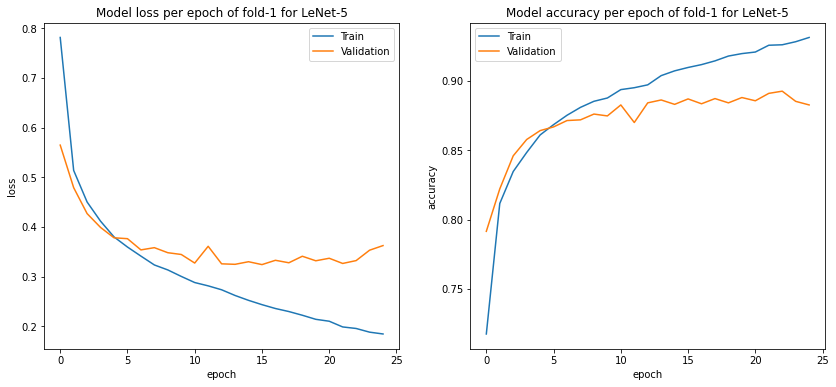

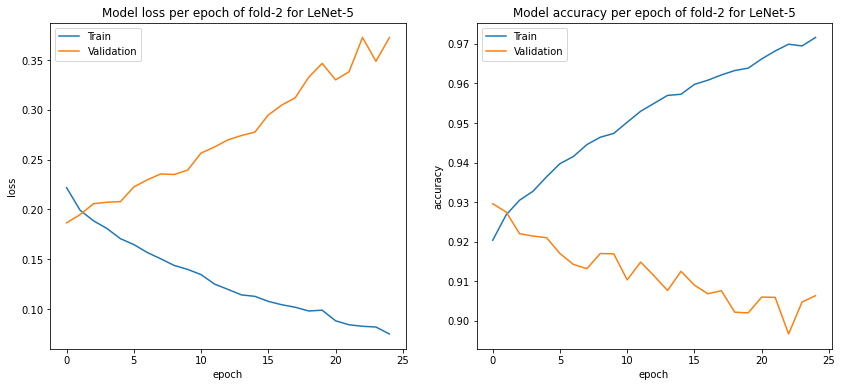

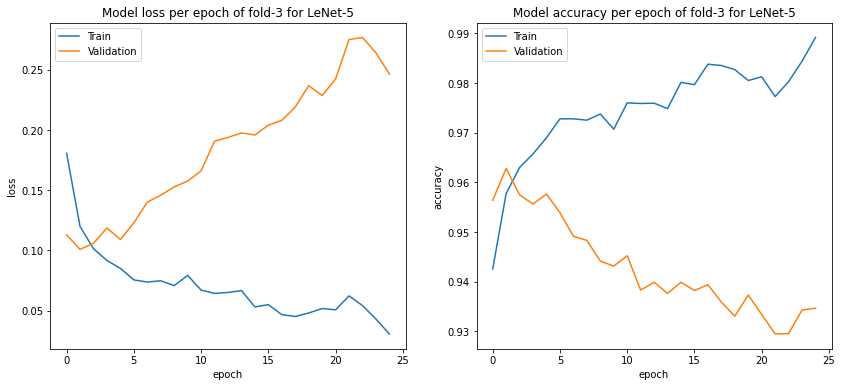

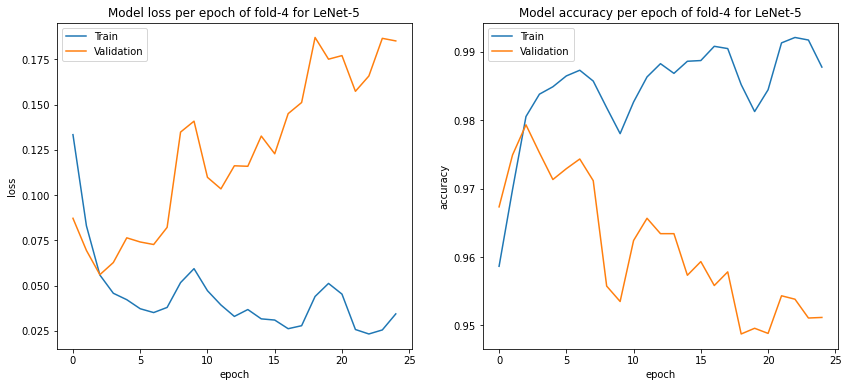

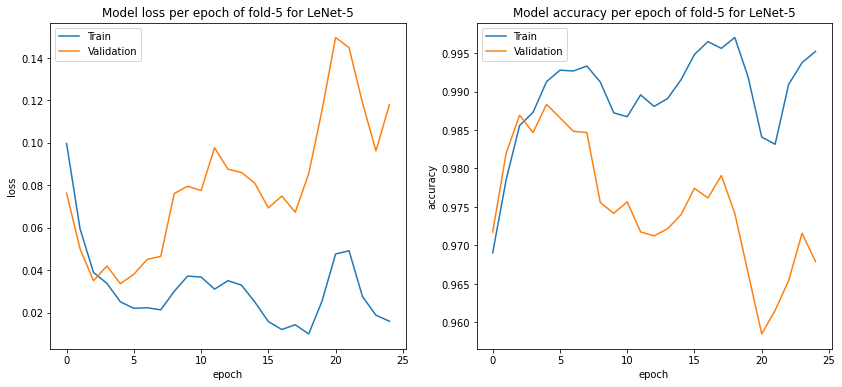

In [22]:
# perform 5 fold cross validation on the modified LeNet-5 model and visualize the results
histories, mean_accuracy, mean_validation_accuracy, mean_loss, mean_validation_loss = k_fold_cross_validation(X_train, y_train, modified_lenet5, 5)
cross_validation_report(histories, mean_accuracy, mean_validation_accuracy, mean_loss, mean_validation_loss, 5)